# GridAges Tutorial: IEEE 13-Bus Microgrid EMS (Single-Agent RL)

This notebook is a **fundamental, end-to-end** tutorial for GridAges using the **IEEE 13-bus microgrid EMS** case.

You will learn:
1. What **Optimal Power Flow (OPF)** is and how EMS relates to OPF.
2. How to formulate EMS as a **Markov Decision Process (MDP)** for single-agent RL.
3. How GridAges implements the physics using **pandapower** power flow.
4. How to run a **one-step power flow** (and a minimal OPF attempt) and inspect results.
5. How to train **PPO** with Stable-Baselines3 and evaluate a learned controller.

> Repo: https://github.com/hepengli/GridAges.git

## 1. Energy Management System (EMS) at the grid edge

At the grid edge (e.g., a microgrid), an **Energy Management System (EMS)** decides how to operate controllable assets over time, such as:
- batteries (ESS),
- dispatchable generators (DG),
- renewable sources (PV, wind),
- grid import/export at the point of common coupling (PCC),
while respecting **network physics** and **operational constraints** (voltages, line/transformer limits, device limits).

At each time step (e.g., hourly), the EMS answers:

> **How should each controllable device operate now**, given current measurements and uncertain future conditions?

## IEEE 13-Bus Microgrid Example

The figure below illustrates the **IEEE 13-bus microgrid** used throughout this tutorial.

It includes:
- dispatchable generators (DG),
- renewable generation (solar and wind),
- battery energy storage (ESS),
- loads,
- transformers and feeders,
- and a point of common coupling (PCC) to the upstream grid.

This physical network is modeled using **pandapower**, while control decisions are made
by a learning-based Energy Management System (EMS).

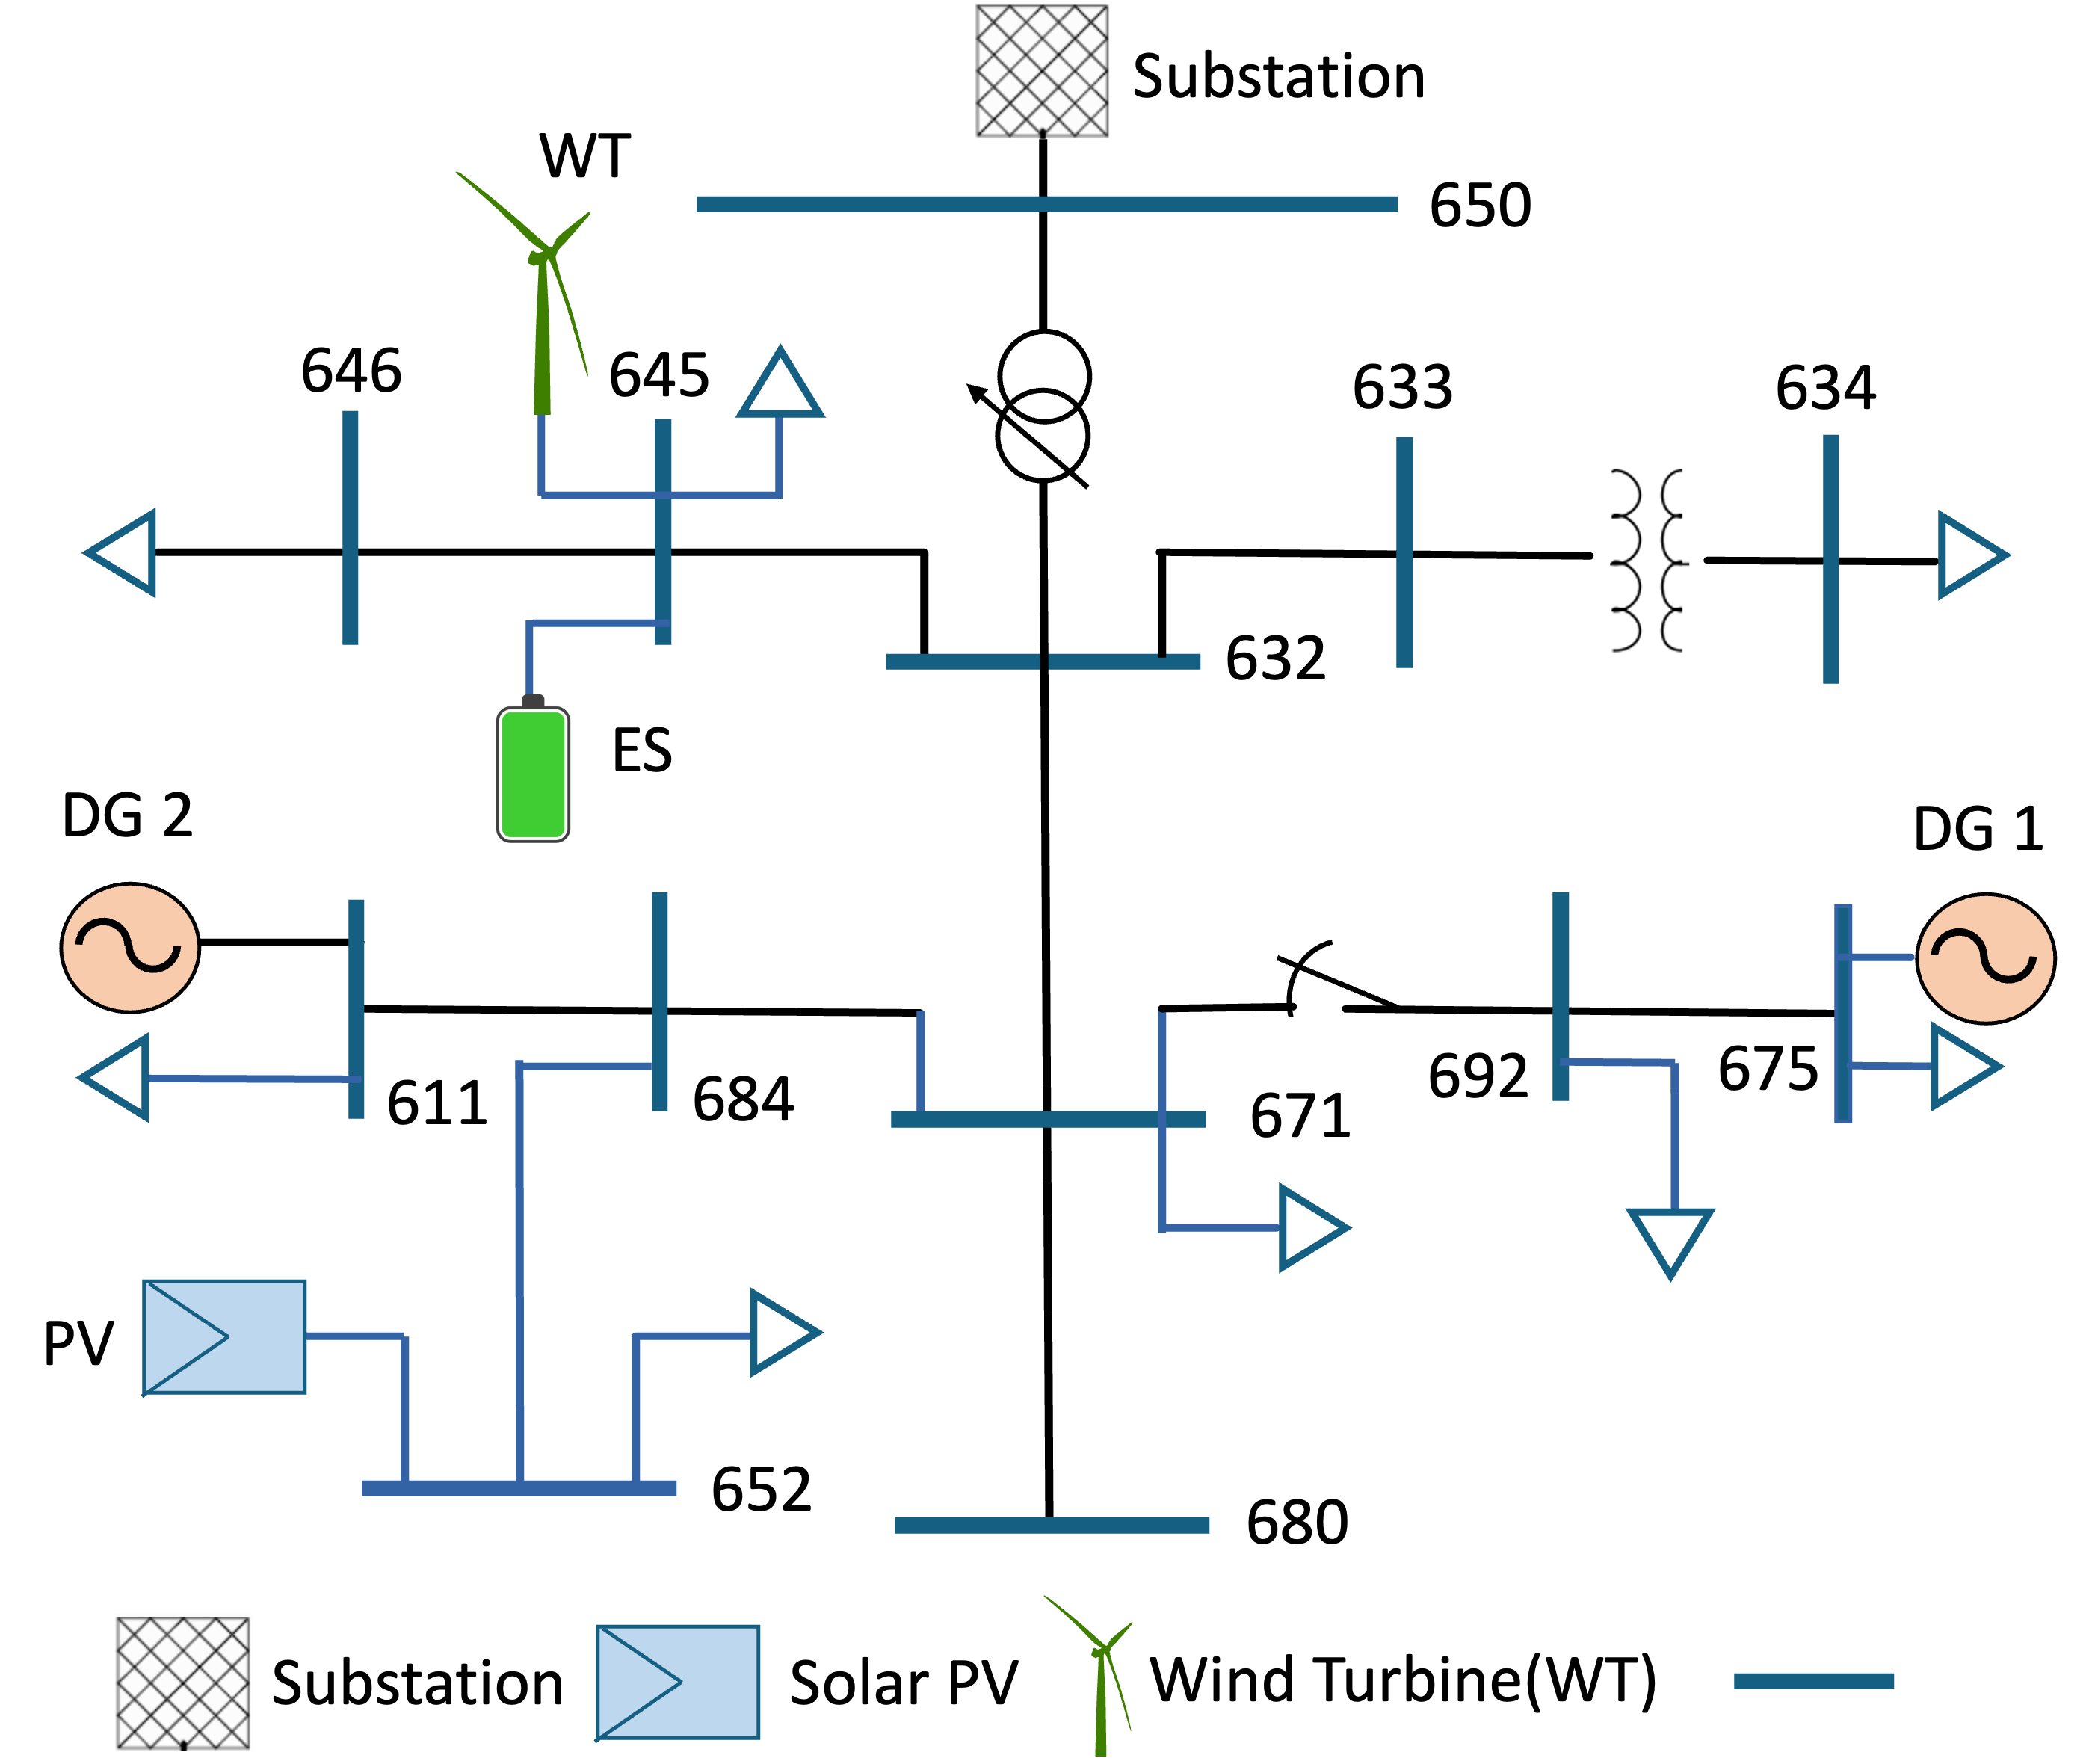

## 2. EMS as Optimal Power Flow (OPF)

### 2.1 AC power flow constraint (physics)

The electric network is governed (approximately) by the AC power flow equations. In optimization form, one can write:

\begin{equation}
\mathbf{f}(\mathbf{x}_t, \mathbf{u}_t, \boldsymbol{\xi}_t) = 0
\end{equation}

- $\mathbf{x}_t$: network states (e.g., bus voltage magnitudes/angles)
- $\mathbf{u}_t$: control decisions (generator outputs, ESS power, tap positions, etc.)
- $\boldsymbol{\xi}_t$: exogenous inputs (loads, renewable availability)

In GridAges, these physics are solved by **pandapower** (`pandapower.runpp`).

### 2.2 Single-period OPF (one time step)

A simplified single-period OPF is:

\begin{equation}
\begin{aligned}
\min_{\mathbf{u}_t} \quad
& \sum_{i \in \mathcal{G}} C_i(P_{i,t}) + C^{\text{grid}}_t(P^{\text{grid}}_t) \\
\text{s.t.}\quad
& \mathbf{f}(\mathbf{x}_t, \mathbf{u}_t, \boldsymbol{\xi}_t) = 0 \\
& \underline{V} \le V_{n,t} \le \overline{V} \qquad \forall n \\
& \underline{P}_i \le P_{i,t} \le \overline{P}_i \qquad \forall i \\
& S_{\ell,t} \le \overline{S}_\ell \qquad \forall \ell
\end{aligned}
\end{equation}

- $C_i(\cdot)$ is a generator cost curve (often quadratic or piecewise linear).
- Grid import/export cost is often price-based: $C^{\text{grid}}_t(\cdot)$.

### 2.3 Multi-period OPF (dynamic EMS)

Real EMS is *sequential* due to inter-temporal constraints (especially storage). Over a horizon $T$:

\begin{equation}
\min_{\{\mathbf{u}_t\}_{t=0}^{T-1}}
\sum_{t=0}^{T-1} \gamma^t \left[
\sum_i C_i(P_{i,t}) + C^{\text{grid}}_t(P^{\text{grid}}_t)
\right]
\end{equation}

subject to the power flow constraints at each \(t\), plus device dynamics. For a battery, a common discretized SOC model is:

\begin{equation}
\text{SOC}_{t+1} =
\text{SOC}_{t} +
\eta_{\text{ch}} P^{\text{ch}}_{t}\Delta t -
\frac{1}{\eta_{\text{dis}}} P^{\text{dis}}_{t}\Delta t
\end{equation}

(Implementations vary; GridAges uses an internal ESS state update consistent with its device model.)

### 2.4 Why not just solve OPF?

Multi-period AC-OPF is:
- nonlinear and nonconvex,
- sensitive to forecasting errors (loads, renewables, prices),
- expensive if solved repeatedly online,
- complicated by discrete decisions (commitment, tap positions, switches).

This motivates **feedback policies** learned by RL.

## 3. EMS as an MDP (single-agent RL)

We define an MDP $(\mathcal{S}, \mathcal{A}, P, r, \gamma)$:

### 3.1 State / observation $s_t$

A practical observation typically includes:
- device states (e.g., battery SOC, generator status),
- network measurements (voltages, loading),
- exogenous context (current load level, renewable availability, price),
- optional time features (hour-of-day).

GridAges builds this observation from:
- device state vectors,
- pandapower results (`net.res_bus`, `net.res_line`, etc.),
- dataset time series.

### 3.2 Action $a_t$

The action is a concatenation of per-device controls in a fixed device order, mixing:
- continuous setpoints (e.g., active power),
- optional discrete controls (on/off, tap positions).

### 3.3 Transition dynamics $P(s_{t+1}\mid s_t,a_t)$

The environment transitions by:
1. applying exogenous time series at time $t$ (load/RES/price),
2. applying the action to device setpoints,
3. solving power flow,
4. updating internal device states (e.g., SOC).

### 3.4 Reward $r_t$

A standard design derives reward from the OPF objective:

\begin{equation}
r_t^{\text{econ}} = -\left(\sum_i C_i(P_{i,t}) + C^{\text{grid}}_t(P^{\text{grid}}_t)\right)
\end{equation}

### 3.5 Constraints (voltages, lines, device limits)

There are two common strategies:

**(A) Soft constraints (penalty shaping)**  
Add penalties for constraint violations:

\begin{equation}
r_t = r_t^{\text{econ}} - \lambda^{\text{volt}} \sum_n \phi(V_{n,t})
- \lambda^{\text{line}} \sum_\ell \phi(S_{\ell,t})
- \lambda^{\text{dev}} \sum_i \phi_i
\end{equation}

**(B) Constrained RL (track safety separately)**  
Keep reward and safety separate, and apply constrained-RL methods externally.
GridAges exposes safety signals in `info` so you can do either (A) or (B).

### 3.6 Uncertainty (load / DER / price)

In practice, load demand, renewable generation (solar and wind), and electricity prices
are uncertain and only imperfectly predictable. Rather than assuming an explicit
parametric stochastic model, **GridAges simulates uncertainty using historical time-series data**.

In this tutorial, we use a **one-year real-world dataset from the California ISO (CAISO)**,
which provides time series for:
- electricity demand (load),
- renewable generation availability (solar and wind),
- locational electricity prices.

All time series are **normalized** and aligned to a common temporal resolution
(e.g., hourly), and are treated as **exogenous inputs** to the environment.

During simulation:
- At each environment step, the simulator advances the dataset by one time index.
- The agent observes only the **current values** of load, renewable availability, and price.
- Future values are not revealed to the agent.

During training, uncertainty is introduced by:
- sampling a **random start time** (e.g., a random day) from the one-year dataset at `reset()`,
- rolling forward sequentially through the dataset within each episode.

This approach exposes the agent to a wide range of realistic operating conditions
while preserving **temporal correlations** in load, renewable generation, and prices,
which are critical in power system operations and difficult to capture with simple noise models.

As a result, the learned policy is a **feedback control law**,

$$
\pi(a_t \mid s_t),
$$

that maps current observations to control actions, rather than an open-loop schedule
that relies on perfect forecasts. This dataset-driven formulation provides a practical,
reproducible way to study EMS decision-making under uncertainty using real system data.



## 4. Setup

### 4.1 Install dependencies

```bash
pip install -e .
pip install stable-baselines3 tensorboard
```

### 4.2 Dataset

`IEEE13Env` expects a dataset file at:

```
<repo_root>/data/data2023-2024.pkl
```

If you don't have the dataset yet, place it there (or adapt `read_data()` in
`gridages/envs/single_agent/microgrid_ems/ieee13_mg.py`).

In [13]:
import numpy as np
import pandas as pd
import pandapower as pp

from gridages.envs.single_agent.microgrid_ems.ieee13_mg import IEEE13Env

In [17]:
env_config = {
    "train": True,            # sample a random day start on reset()
    "episode_length": 24,     # 24 timesteps per episode (e.g., hours)
    "load_scale": 1.0,
    "base_power": 1.0,

    # Optional: if your base env supports automatic safety penalties.
    "reward_scale": 1.0,
    "safety_scale": 0.0,      # set >0 to penalize safety
    "max_penalty": 0.0,
}

env = IEEE13Env(env_config)
obs, info = env.reset(seed=0)
print("obs shape:", np.shape(obs))
print("info keys:", list(info.keys())[:10])

obs shape: (65,)
info keys: ['t']


In [19]:
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)
print("\nDevice order (action/state order):")
for i, name in enumerate(env.devices.keys()):
    print(f"  [{i}] {name}")

Action space: Box([-0.5    0.    -0.3    0.    -0.375], [0.5   0.4   0.3   0.5   0.375], (5,), float32)
Observation space: Box(-inf, inf, (65,), float32)

Device order (action/state order):
  [0] ESS1
  [1] DG1
  [2] DG2
  [3] PV1
  [4] WT1
  [5] Grid
  [6] Substation
  [7] Transformer 1


## 5. One-step power flow with pandapower (inspect voltages and line loading)

GridAges runs `pandapower.runpp(net)` internally each step. Here we'll do a minimal, transparent demonstration:
- take the `net` from the environment after `reset`,
- run a power flow once,
- display a few key outputs.

This helps users connect the RL environment to familiar power-systems quantities.

In [21]:
# Copy the pandapower network so we don't accidentally mutate the env's internal net.
net = env.net.deepcopy()

# Run a single AC power flow
pp.runpp(net)

# Show bus voltage magnitudes (p.u.)
bus_v = net.res_bus[["vm_pu"]].copy()
bus_v.index = net.bus["name"].values
bus_v.sort_values("vm_pu").head(10)

,vm_pu
MG1 Bus 675,0.964806
MG1 Bus 652,0.965426
MG1 Bus 611,0.965536
MG1 Bus 684,0.965688
MG1 Bus 671,0.966181
MG1 Bus 692,0.966181
MG1 Bus 680,0.966181
MG1 Bus 634,0.972366
MG1 Bus 646,0.979503
MG1 Bus 645,0.979889


In [26]:
# Show line loading (if lines exist in this network)
if hasattr(net, "res_line") and len(net.line) > 0:
    line_loading = net.res_line[["loading_percent"]].copy()
    line_loading.index = net.line["name"].where(
        net.line["name"].notna(),
        net.line.index.astype(str)
    )
    display(line_loading.sort_values("loading_percent", ascending=False).head(10))
else:
    print("No line results available (network may be mostly transformers/switches).")

,loading_percent
name,
MG1 Line 5,28.180591
MG1 Line 9,22.248364
MG1 Line 1,10.836769
MG1 Line 6,7.888643
MG1 Line 2,6.303212
MG1 Line 3,6.045417
MG1 Line 4,4.953760
MG1 Line 8,4.345095
MG1 Line 7,0.000138


In [28]:
# Show external grid (P/Q) results if present
if len(net.ext_grid) > 0 and hasattr(net, "res_ext_grid"):
    display(net.res_ext_grid)
else:
    print("No ext_grid results available.")

,p_mw,q_mvar
0,1.586069,1.010872


## 6. A minimal OPF demonstration (pandapower.runopp) — not an EMS baseline

pandapower provides `runopp` for **one-step Optimal Power Flow (OPF)**, which is useful for
demonstrating optimization on the same physical network. However, it is important to clarify:

**This is *not* a baseline for the EMS RL problem in this tutorial.**

Why?
- `runopp` solves a **static, one-step** optimization problem (a snapshot at time \(t\)).
- EMS is inherently **sequential / multi-period** due to inter-temporal constraints (e.g., battery SOC),
  and the controller must operate under **uncertainty** (future load/renewables/price are unknown).
- A fair optimization-based baseline for EMS is typically **Model Predictive Control (MPC)** or a
  **multi-period OPF** solved over a horizon with forecasts (and possibly forecast errors).

In other words:
- `runopp` is a helpful **physics+optimization demo**,
- but it answers a different question than the RL EMS controller.

Below we attempt to run `pandapower.runopp()` and print results if it succeeds.
If it fails, it usually means OPF-specific configuration is missing (e.g., controllable elements or cost functions).


In [31]:
net_opf = env.net.deepcopy()

try:
    # NOTE: This may fail if the network is not configured for OPF (no costs, no controllable elements).
    pp.runopp(net_opf)
    print("OPF converged:", net_opf["OPF_converged"] if "OPF_converged" in net_opf else "unknown")

    # Example outputs
    if hasattr(net_opf, "res_bus"):
        bus_v = net_opf.res_bus[["vm_pu"]].copy()
        bus_v.index = net_opf.bus["name"].values
        display(bus_v.sort_values("vm_pu").head(10))

    if hasattr(net_opf, "res_ext_grid") and len(net_opf.ext_grid) > 0:
        display(net_opf.res_ext_grid)
except Exception as e:
    print("OPF did not run on this net (this is OK for the tutorial).")
    print("Reason:", type(e).__name__, "-", str(e)[:300], "...")

no costs are given - overall generated power is minimized


OPF converged: True


,vm_pu
MG1 Bus 675,0.964806
MG1 Bus 652,0.965426
MG1 Bus 611,0.965536
MG1 Bus 684,0.965688
MG1 Bus 671,0.966181
MG1 Bus 692,0.966181
MG1 Bus 680,0.966181
MG1 Bus 634,0.972366
MG1 Bus 646,0.979503
MG1 Bus 645,0.979889


,p_mw,q_mvar
0,1.586069,1.010872


## 7. Quick rollout with a random policy

This checks:
- reset/step works,
- rewards are finite,
- episodes truncate at the horizon.

In [ ]:
obs, info = env.reset(seed=0)

total_reward = 0.0
for t in range(env_config["episode_length"]):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += float(reward)
    if terminated or truncated:
        break

print("Episode return (random policy):", total_reward)
print("terminated:", terminated, "truncated:", truncated)
print("sample info keys:", sorted(info.keys())[:12])

## 8. Training PPO (Stable-Baselines3)

We'll train PPO on `IEEE13Env`.

Tips:
- Start small (50k–200k steps) to validate.
- Then scale to 1M+ steps for better performance.
- Tune `safety_scale` or penalty terms if you see many violations.

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

train_env = DummyVecEnv([lambda: Monitor(IEEE13Env(env_config))])

model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    n_steps=1024,
    batch_size=256,
    gamma=0.99,
    learning_rate=3e-4,
    ent_coef=0.0,
    clip_range=0.2,
    tensorboard_log="./tb_ieee13_ppo/",
)

total_timesteps = 200_000  # increase to 1_000_000+ for better policies
model.learn(total_timesteps=total_timesteps, progress_bar=True)

## 9. Evaluate the trained policy

We'll run a few evaluation episodes and compute average return.

In [ ]:
def evaluate(model, n_episodes=5, seed=123):
    returns = []
    for ep in range(n_episodes):
        eval_env = IEEE13Env({**env_config, "train": False})
        obs, info = eval_env.reset(seed=seed + ep)
        done = False
        ep_ret = 0.0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            ep_ret += float(reward)
            done = bool(terminated or truncated)

        returns.append(ep_ret)

    return float(np.mean(returns)), float(np.std(returns)), returns

mean_ret, std_ret, rets = evaluate(model, n_episodes=5)
print("Mean return:", mean_ret)
print("Std return:", std_ret)
print("Returns:", rets)

## 10. TensorBoard

Start TensorBoard:

```bash
tensorboard --logdir ./tb_ieee13_ppo
```

Look at:
- episode return curves,
- value loss / policy loss stability,
- entropy (exploration).

## 11. Customization guide (what users change first)

### 11.1 Device mix and limits
Edit `IEEE13Env._build_net()`:
- add/remove ESS/DG/RES devices,
- adjust limits (`min_p_mw`, `max_p_mw`, SOC bounds),
- change generator cost curves.

### 11.2 Uncertainty sources
In `read_data()`, choose different:
- load area,
- renewable area,
- price node.

### 11.3 Constraints: penalties vs constrained RL
- Use penalty shaping (soft constraints) by adding penalty weights.
- Or keep safety separate and use constrained RL methods externally.
GridAges exposes safety signals via `info`.

### 11.4 Build your own single-agent case
Copy `ieee13_mg.py` and implement:
- `_build_net()`
- `_reward_and_safety()`